In [2]:
from tqdm import tqdm_notebook as tqdm
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Flatten, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import get_file
from tensorflow.keras import layers
from imblearn.over_sampling import RandomOverSampler
import tensorflow
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
import sklearn
import os
import cv2

In [20]:
import os
import gc
import psutil
import pandas as pd
import numpy  as np 


process = psutil.Process(os.getpid())
print('start', process.memory_info().rss)

mtx  = np.zeros((100000000, 1)).astype('int')
df   = pd.DataFrame(mtx)

print('df created', process.memory_info().rss)

del df;  gc.collect()

print('df deleted', process.memory_info().rss)

del mtx;  gc.collect()

print('mtx deleted', process.memory_info().rss)

start 10992529408
df created 11786690560
df deleted 10094497792
mtx deleted 9294495744


In [4]:
path = '/kaggle/input/aptos2019-blindness-detection/'

In [5]:
df = pd.read_csv(path + 'train.csv', sep = ',')
files = os.listdir(path + 'train_images')

In [6]:
img_train_list = []

def imgPreprocessing(files):
    for i in tqdm(files):
        image = cv2.imread(path + 'train_images/' + i)
        image = cv2.resize(image,(250, 250))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        image = cv2.equalizeHist(image)
        image = cv2.medianBlur(image, 3)
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
        img_train_list.append(image)

In [7]:
imgPreprocessing(files)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


  0%|          | 0/3662 [00:00<?, ?it/s]

In [8]:
df["diagnosis"].value_counts()

0    1805
2     999
1     370
4     295
3     193
Name: diagnosis, dtype: int64

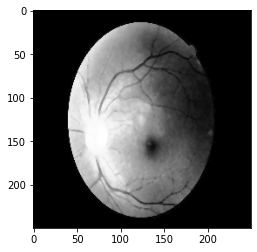

In [9]:
img = img_train_list[0]
plt.imshow(img)

In [10]:
y = df['diagnosis']
y = to_categorical(y)
print(y)

[[0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]
 ...
 [0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]]


In [11]:
x = np.array(img_train_list)
x.shape, y.shape

((3662, 250, 250, 3), (3662, 5))

In [12]:
x = x.reshape(x.shape[0],-1)
x.shape

(3662, 187500)

In [13]:
over_sampler = RandomOverSampler(random_state=42)
x_res, y_res = over_sampler.fit_resample(x, y)

In [14]:
x_res = x_res.reshape(-1,250,250,3)
x_res.shape

(9025, 250, 250, 3)

In [15]:
x_train, x_val, y_train, y_val = train_test_split(x_res, y_res, test_size = 0.2, random_state = 42, shuffle=True) 
x_train.shape, x_val.shape, y_train.shape, y_val.shape

((7220, 250, 250, 3), (1805, 250, 250, 3), (7220, 5), (1805, 5))

In [21]:
base_model = tensorflow.keras.applications.EfficientNetB5(include_top=False)

base_model.trainable = True

for layer in base_model.layers[:-10]:
    layer.trainable = False
    
inputs = tensorflow.keras.layers.Input(shape=(250, 250, 3))
x = base_model(inputs)
x = tensorflow.keras.layers.GlobalAveragePooling2D()(x)
x = tensorflow.keras.layers.Dropout(0.5)(x)
outputs = tensorflow.keras.layers.Dense(5, activation="sigmoid")(x)
model = tensorflow.keras.Model(inputs, outputs)

model.summary()

115277824/115263384 [==============================] - 1s 0us/step
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 250, 250, 3)]     0         
_________________________________________________________________
efficientnetb5 (Functional)  (None, None, None, 2048)  28513527  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 2048)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 10245     
Total params: 28,523,772
Trainable params: 3,426,437
Non-trainable params: 25,097,335
_________________________________________________________________


In [23]:
model = Sequential()
model.add(tensorflow.keras.applications.EfficientNetB0(weights = 'imagenet', include_top = False, input_shape = (250, 250, 3)))
model.add(layers.GlobalAveragePooling2D())
model.add(BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(5, activation = 'sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb0 (Functional)  (None, 8, 8, 1280)        4049571   
_________________________________________________________________
global_average_pooling2d_4 ( (None, 1280)              0         
_________________________________________________________________
module_wrapper (ModuleWrappe (None, 1280)              5120      
_________________________________________________________________
dropout_4 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 6405      
Total params: 4,061,096
Trainable params: 4,016,513
Non-trainable params: 44,583
_________________________________________________________________


In [22]:
model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0005), metrics=['accuracy'])
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=30)

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")
2023-02-01 14:25:31.473311: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1353750000 exceeds 10% of free system memory.


Epoch 1/30
226/226 [==============================] - 93s 350ms/step - loss: 0.4922 - accuracy: 0.2963 - val_loss: 0.4604 - val_accuracy: 0.3950
Epoch 2/30
226/226 [==============================] - 73s 324ms/step - loss: 0.4261 - accuracy: 0.4645 - val_loss: 0.3955 - val_accuracy: 0.5125
Epoch 3/30
226/226 [==============================] - 73s 324ms/step - loss: 0.3676 - accuracy: 0.5758 - val_loss: 0.3417 - val_accuracy: 0.6139
Epoch 4/30
226/226 [==============================] - 73s 324ms/step - loss: 0.3254 - accuracy: 0.6370 - val_loss: 0.3053 - val_accuracy: 0.6709
Epoch 5/30
226/226 [==============================] - 73s 324ms/step - loss: 0.2938 - accuracy: 0.6864 - val_loss: 0.2806 - val_accuracy: 0.7014
Epoch 6/30
226/226 [==============================] - 73s 323ms/step - loss: 0.2665 - accuracy: 0.7248 - val_loss: 0.2681 - val_accuracy: 0.7147
Epoch 7/30
226/226 [==============================] - 73s 324ms/step - loss: 0.2481 - accuracy: 0.7542 - val_loss: 0.2389 - val_ac

       loss  accuracy  val_loss  val_accuracy
0  0.492221  0.296260  0.460434      0.395014
1  0.426088  0.464543  0.395469      0.512465
2  0.367561  0.575762  0.341680      0.613850
3  0.325385  0.636981  0.305256      0.670914
4  0.293839  0.686427  0.280585      0.701385


<AxesSubplot:>

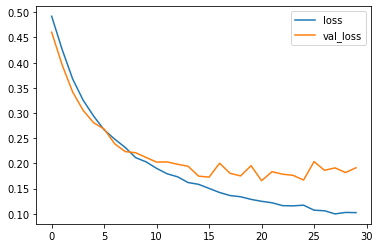

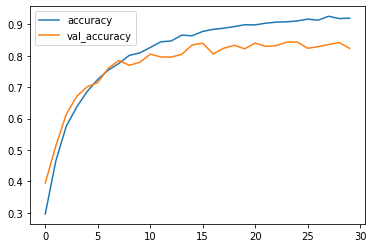

In [23]:
#model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0005), metrics=['accuracy'])
#history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=30)
#loss:0.1021 acc:0.9195 val_loss:0.1912 val_acc:0.8233 EfficientNetB5 -> fine tuning ile
history_df = pd.DataFrame(history.history)
print(history_df.head())

history_df[['loss', 'val_loss']].plot()
history_df[['accuracy', 'val_accuracy']].plot()

       loss  accuracy  val_loss  val_accuracy
0  0.499121  0.300693  0.461513      0.404986
1  0.437802  0.434903  0.402525      0.500831
2  0.386552  0.537812  0.351234      0.581717
3  0.350064  0.595152  0.313657      0.661496
4  0.317246  0.650831  0.276360      0.711911


<AxesSubplot:>

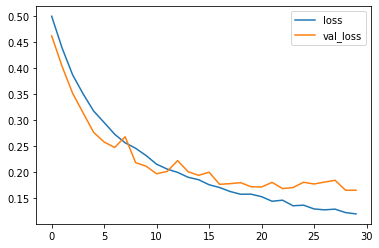

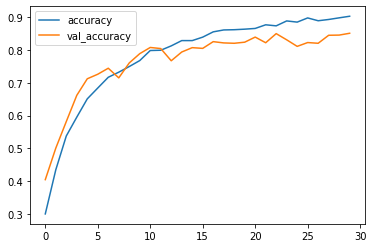

In [19]:
#model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0005), metrics=['accuracy'])
#history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=30)
#loss:0.1200 acc:0.9022 val_loss:0.1654 val_acc:0.8504 EfficientNetB4 -> fine tuning ile
history_df = pd.DataFrame(history.history)
print(history_df.head())

history_df[['loss', 'val_loss']].plot()
history_df[['accuracy', 'val_accuracy']].plot()

       loss  accuracy  val_loss  val_accuracy
0  0.497196  0.310111  0.465488      0.396122
1  0.429644  0.455540  0.395363      0.539058
2  0.381595  0.545568  0.365966      0.557341
3  0.340347  0.611496  0.326659      0.622161
4  0.308971  0.658310  0.293650      0.685319


<AxesSubplot:>

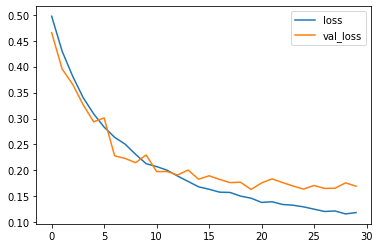

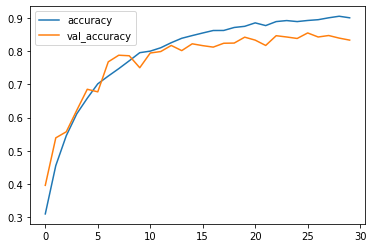

In [36]:
#model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0005), metrics=['accuracy'])
#history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=30)
#loss:0.1186 acc:0.9004 val_loss:0.1695 val_acc:0.8332 EfficientNetB3 -> fine tuning ile
history_df = pd.DataFrame(history.history)
print(history_df.head())

history_df[['loss', 'val_loss']].plot()
history_df[['accuracy', 'val_accuracy']].plot()

       loss  accuracy  val_loss  val_accuracy
0  0.496497  0.307479  0.460576      0.425485
1  0.438135  0.433657  0.427006      0.464266
2  0.391313  0.526593  0.373352      0.559003
3  0.356221  0.584903  0.327338      0.630471
4  0.327903  0.638089  0.317451      0.629363


<AxesSubplot:>

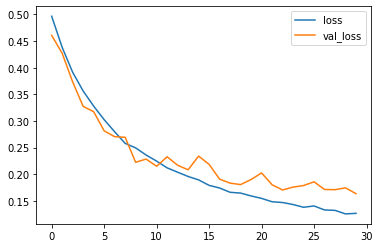

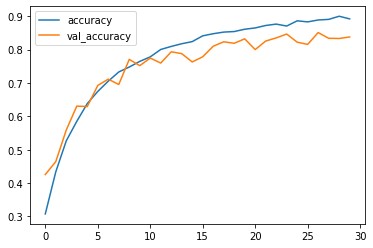

In [22]:
#model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0005), metrics=['accuracy'])
#history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=30)
#loss:0.1167 acc:0.8920 val_loss:0.1636 val_acc:0.8377 EfficientNetB2 -> fine tuning ile
history_df = pd.DataFrame(history.history)
print(history_df.head())

history_df[['loss', 'val_loss']].plot()
history_df[['accuracy', 'val_accuracy']].plot()

       loss  accuracy  val_loss  val_accuracy
0  0.498974  0.287535  0.461707      0.413296
1  0.438109  0.436150  0.409699      0.530748
2  0.384899  0.549723  0.369845      0.567867
3  0.345622  0.614266  0.332663      0.613850
4  0.311840  0.663989  0.283686      0.700831


<AxesSubplot:>

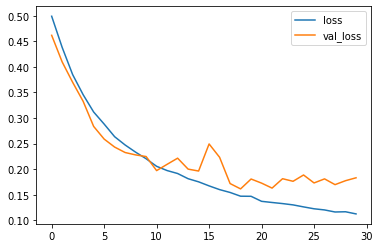

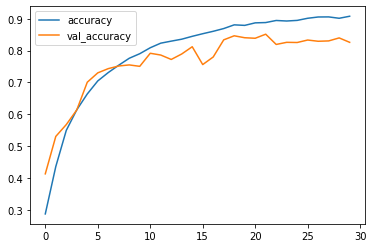

In [18]:
#model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0005), metrics=['accuracy'])
#history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=30)
#loss:0.1127 acc:0.9079 val_loss:0.1833 val_acc:0.8260 EfficientNetB1 -> fine tuning ile
history_df = pd.DataFrame(history.history)
print(history_df.head())

history_df[['loss', 'val_loss']].plot()
history_df[['accuracy', 'val_accuracy']].plot()

       loss  accuracy  val_loss  val_accuracy
0  0.320148  0.662327  0.299553      0.678670
1  0.290069  0.700415  0.307132      0.635457
2  0.262457  0.746814  0.272975      0.698615
3  0.242237  0.773546  0.238034      0.768421
4  0.219948  0.799861  0.233750      0.769529


<AxesSubplot:>

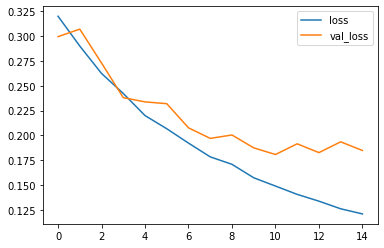

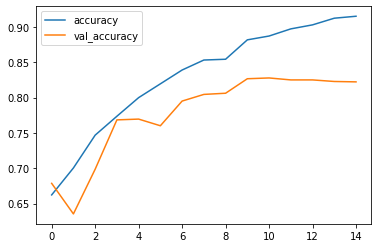

In [19]:
#model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0005), metrics=['accuracy'])
#history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=15)
#loss:0.1207 acc:0.9150 val_loss:0.1847 val_acc:0.8222 EfficientNetB0 -> fine tuning ile
history_df = pd.DataFrame(history.history)
print(history_df.head())

history_df[['loss', 'val_loss']].plot()
history_df[['accuracy', 'val_accuracy']].plot()